In [2]:
import os
import sys
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.prompts import PromptTemplate

from langchain_core.retrievers import BaseRetriever
from typing import Dict, Any
from langchain.docstore.document import Document
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate


In [3]:
import os
from config import HF_TOKEN, open_ai_key
import warnings
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_huggingface  import HuggingFaceEmbeddings
from langchain_ollama import ChatOllama

# Ignore all the warnings given by different packages
warnings.filterwarnings('ignore')

# Retrieve the open ai and hf tokens from the configuration file
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["OPENAI_API_KEY"] = open_ai_key

# Select the GPU as the device
model_kwargs = {'device': 'cuda'}

# Required for fast similarity computations
encode_kwargs = {'normalize_embeddings': True}

# Initialize Embeddings, GPT and Ollama Model
llm_gpt = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=open_ai_key)

llm_text = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_thread = 2,
    format = ''
)

llm_json = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_thread = 2,
    format = 'json'
)

model_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

# HyDE Retriever

In [4]:
import json
from utils1 import *

class HyDERetriever:
    def __init__(self,  vectordb, chunk_size=500, chunk_overlap=100):
        self.llm = llm_text

        self.embeddings = model_embeddings
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.vectorstore = vectordb
    
        
        self.hyde_prompt = PromptTemplate(
            input_variables=["query", "chunk_size"],
            template="""Given the question '{query}' from the domain of Indian Human Resource Laws and Policies, generate a hypothetical document that directly answers this question. The document should be detailed and in-depth.
            the document size has be exactly {chunk_size} characters. Don't give json response""",
        )
        self.hyde_chain = self.hyde_prompt | self.llm

    def generate_hypothetical_document(self, query):
        input_variables = {"query": query, "chunk_size": self.chunk_size}
        return self.hyde_chain.invoke(input_variables).content

    def retrieve(self, query, k=3):
        hypothetical_doc = self.generate_hypothetical_document(query)
        similar_docs = self.vectorstore.similarity_search(hypothetical_doc, k=k)
        return similar_docs, hypothetical_doc

In [5]:
import time
import json

with open("test_data_30.json", "r") as file:
    cleaned_data = json.load(file)

In [6]:
class AnswerStructure(BaseModel):
    answer: str = Field(description="answer to the given question")

parser = JsonOutputParser(pydantic_object=AnswerStructure)

import time
def get_llm_response(query, vectordb):
    # pull the prompt from HF hub
    prompt = """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. Give a detailed answer to the question by reading the context
    \nQuestion: {question} \nContext: {context}
    Give answer in the below json format only. No deviations:
    {{
        "answer":str
    }}
    Your response must be strictly valid JSON with no additional text, markdown formatting, or commentary.
    Make sure to have the key with the name "answer"
    don't include any backticks like ``` or any text like ```json while starting the json
"""

    SYSTEM_PROMPT = PromptTemplate(
    input_variables=["context", "question"], template=prompt
)

    # create a chain with prompt and llama 3.2 1B llm
    rag_chain_from_docs = (
            RunnablePassthrough()
            | SYSTEM_PROMPT
            | llm_json
            | parser
        )

    retriever = HyDERetriever(vectordb)
    try:
        results, hypothetical_doc = retriever.retrieve(query)
    except Exception as e:
        print(str(e))
        time.sleep(5)
        results, hypothetical_doc = retriever.retrieve(query)

    docs_content = {i: doc.page_content for i, doc in enumerate(results)}
    docs_content[len(docs_content)] = hypothetical_doc

    try:
        result = rag_chain_from_docs.invoke({"question": query, "context": docs_content})
    except Exception as e:
        print(str(e))
        time.sleep(5)
        result = rag_chain_from_docs.invoke({"question": query, "context": docs_content})
    
    return result["answer"], list(docs_content.values())

In [7]:
import concurrent.futures
import tqdm

def process_llm_response(k, v, vectordb):
    """Function to fetch LLM response in parallel."""
    answer, context = get_llm_response(v["question"], vectordb)
    return k, {"question": v["question"], "answer": answer, "context":context}

def get_response(cleaned_data, vectordb):
    llm_response_data = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(process_llm_response, k, v, vectordb): k for k, v in cleaned_data.items()}
        
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            k, result = future.result()
            llm_response_data[k] = result
        return llm_response_data

In [8]:
import pandas as pd
from ragas import SingleTurnSample, EvaluationDataset
from ragas import evaluate
from ragas.run_config import RunConfig
import warnings
import random
import time

from ragas.metrics import LLMContextPrecisionWithReference, LLMContextRecall, ResponseRelevancy, Faithfulness

warnings.filterwarnings('ignore')
        
def save_evaluator_results(result, name):
    result.to_csv(f"evaluation_{name}.csv")

def evaluator(name, cleaned_data, vectordb):
    data_list = []
    
    # Get Response from the selected Vector DB
    llm_response_data = get_response(cleaned_data, vectordb)

    # Persist the response for later usage
    with open(f"llm_response_data_{name}.json", "w") as file:
        json.dump(llm_response_data, file, indent=4)

    # Create an evaluation dataset
    for k, v in llm_response_data.items():
        row = SingleTurnSample(
            user_input=v["question"],
            retrieved_contexts=v["context"],
            response=v["answer"],
            reference=cleaned_data[k]["answer"],
            reference_contexts = [cleaned_data[k]["answer"]]
        )
    
        data_list.append(row)
    dataset = EvaluationDataset(samples=data_list)
    

    # To make the evaluation faster, we will go with two metrics at a time
    result_1 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[LLMContextPrecisionWithReference(), LLMContextRecall()]).to_pandas()

    # Adding a sleep timer to avoid rate limit or token limit error
    time.sleep(30)
    
    result_2 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[ResponseRelevancy(), Faithfulness()]).to_pandas()

    # Merge all the metrics
    result = pd.merge(result_1, result_2[['user_input', 'answer_relevancy', 'faithfulness']], on='user_input')

    # Persist the metrics result for the experiment
    save_evaluator_results(result, name)
    
    return result

In [12]:
all_experiments = [
"recursive_4096",
"recursive_2048",
"recursive_512",
"recursive_256",
"recursive_1024",
"fixed",
"semantic",
"page",
"agentic",
"agentic_custom",
"semantic_percentile",
"semantic_iq",
"semantic_sd",
"semantic_gradient"]

all_vector_dbs = {}
# results = {}

for e in all_experiments:
    all_vector_dbs[e] = create_or_load_vector_db(chunked_documents="", persist_directory=f"./vector_store_{e}", load=True)

In [13]:
for experiment_name, experiment_db in all_vector_dbs.items():
    results[experiment_name] = evaluator("hyde_"+experiment_name, cleaned_data, experiment_db)
    time.sleep(5)
    print(f"experiment {experiment_name} completed")

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.68it/s]


experiment semantic_iq completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:42<00:00,  1.41it/s]


experiment semantic_sd completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:31<00:00,  1.90it/s]


experiment semantic_gradient completed


In [2]:
all_experiments = ["recursive_4096",
"recursive_2048",
"recursive_512",
"recursive_256",
"recursive_1024",
"fixed",
"semantic",
"page",
"agentic",
"agentic_custom",
"semantic_percentile",
"semantic_iq",
"semantic_sd",
"semantic_gradient"]

import pandas as pd
results = {}
for e in all_experiments:
    results[e] = pd.read_csv(f"evaluation_hyde_{e}.csv").head()

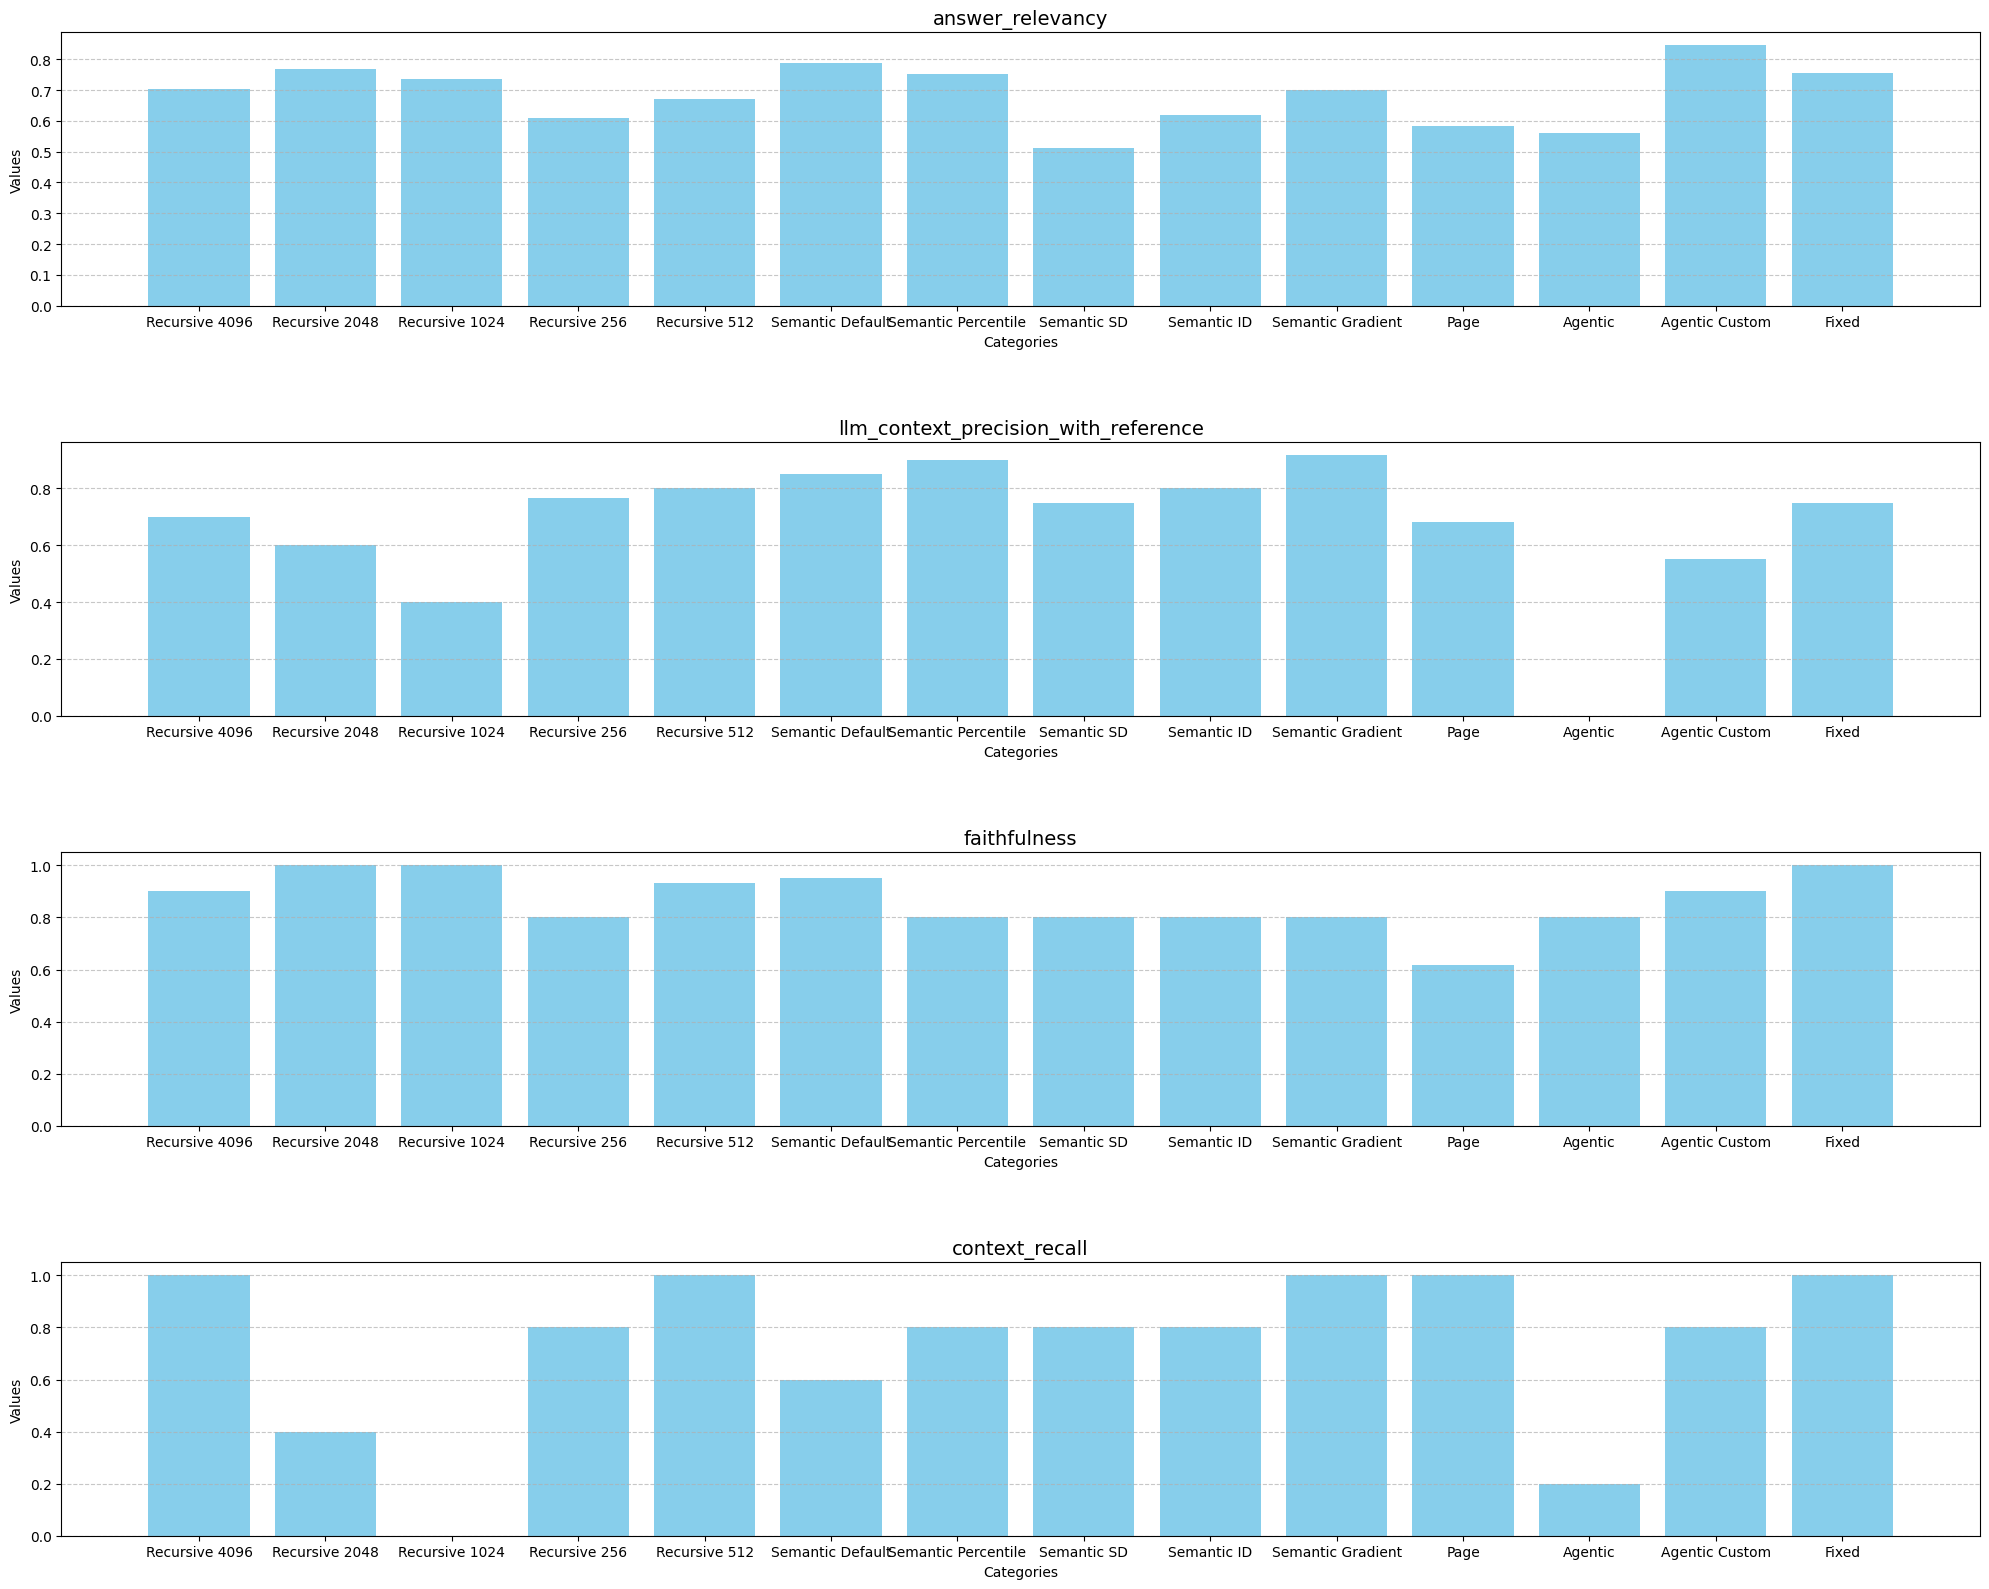

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# categories = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]

categories = ["Recursive 4096", "Recursive 2048", "Recursive 1024", "Recursive 256", "Recursive 512", "Semantic Default", "Semantic Percentile", 
              "Semantic SD", "Semantic ID", "Semantic Gradient", "Page", "Agentic", "Agentic Custom", "Fixed"]


metrics = ["answer_relevancy", "llm_context_precision_with_reference", "faithfulness", "context_recall"]

values = []
for m in metrics:
    values.append([
    np.mean(np.nan_to_num(results["recursive_4096"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_2048"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_1024"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_256"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_512"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_percentile"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_sd"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_iq"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_gradient"][m], nan=0)),
    np.mean(np.nan_to_num(results["page"][m], nan=0)),
    np.mean(np.nan_to_num(results["agentic"][m], nan=0)),
    np.mean(np.nan_to_num(results["agentic_custom"][m], nan=0)),
    np.mean(np.nan_to_num(results["fixed"][m], nan=0))
])

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4,1, figsize=(20, 16))

# Titles for each subplot
titles = ['Plot 1', 'Plot 2', 'Plot 3', 'Plot 4']

# Iterate over each subplot and create a bar plot
for i, ax in enumerate(axs.flat):
    ax.bar(categories, values[i], color='skyblue')
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and add space between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()

In [62]:
result_2

,user_input,retrieved_contexts,reference_contexts,response,reference,llm_context_precision_with_reference,context_recall,answer_relevancy,faithfulness
0,"Under the HR Policies Act of India, what perce...",[per cent. of such salary or wage. \n(2) In co...,[The HR Policies Act of India specifies a perc...,10,The HR Policies Act of India specifies a perce...,0.000000,1.0,0.335612,1.000000
1,What is the Validation of certain minimum rate...,[during any period specified in this section o...,"[According to the Madhya Pradesh amendment, se...",The Madhya Pradesh amendment introduces signif...,"According to the Madhya Pradesh amendment, sec...",1.000000,1.0,0.785731,1.000000
2,How are orders and decisions of the Corporatio...,[nature specified in section 22 has been refer...,[All orders and decisions of the Corporation a...,The orders and decisions of the Corporation ar...,All orders and decisions of the Corporation ar...,0.500000,1.0,0.998205,1.000000
3,What is the short title of the Act that mandat...,[1 \nTHE EMPLOYMENT EXCHANGES (COMPULSORY NOTI...,[The short title of the Act is 'The Employment...,THE EMPLOYMENT EXCHANGE (COMPULSORY NOTIFICATI...,The short title of the Act is 'The Employment ...,1.000000,1.0,0.915738,1.000000
4,What types of deductions are permitted for the...,[8 \n1[(f) deductions for recovery of advances...,[Deductions for the recovery of advances of wh...,Types of deductions permitted for recovery of ...,Deductions for the recovery of advances of wha...,1.000000,1.0,0.995427,1.000000
5,What is the definition of 'exempted employee' ...,"[apprentice engaged under the Apprentices Act,...",[An 'exempted employee' means an employee who ...,Exempted employee means an employee who is not...,An 'exempted employee' means an employee who i...,1.000000,1.0,0.794055,0.500000
6,How are the registers and records maintained u...,[(a) a register of wages in Form 'D' except in...,[The HR Policies Act of India requires the Boa...,Maintaining Registers and Records under the HR...,The HR Policies Act of India requires the Boar...,1.000000,1.0,0.812778,1.000000
7,What is the last numerical value mentioned in ...,[3 \n \nTHE EMPLOYEES’ PROVIDENT FUNDS AND MI...,[The last numerical value mentioned is 9000.],No specific numerical limit for employee contr...,The last numerical value mentioned is 9000.,0.000000,0.0,0.000000,1.000000
8,What changes are made in section 20 of the HR ...,[Provided that the appropriate Government or s...,"[In Madhya Pradesh, for the provisos to sub-se...",Section 20 of the HR Policy for Madhya Pradesh...,"In Madhya Pradesh, for the provisos to sub-sec...",0.500000,0.0,0.928828,1.000000
9,What is a cause of Bronchopulmonary diseases i...,[silicosis is an essential factor \nin causing...,[Bronchopulmonary diseases are caused by hard ...,Asbestos exposure and formaldehyde exposure ar...,Bronchopulmonary diseases are caused by hard m...,0.833333,1.0,0.986968,1.000000


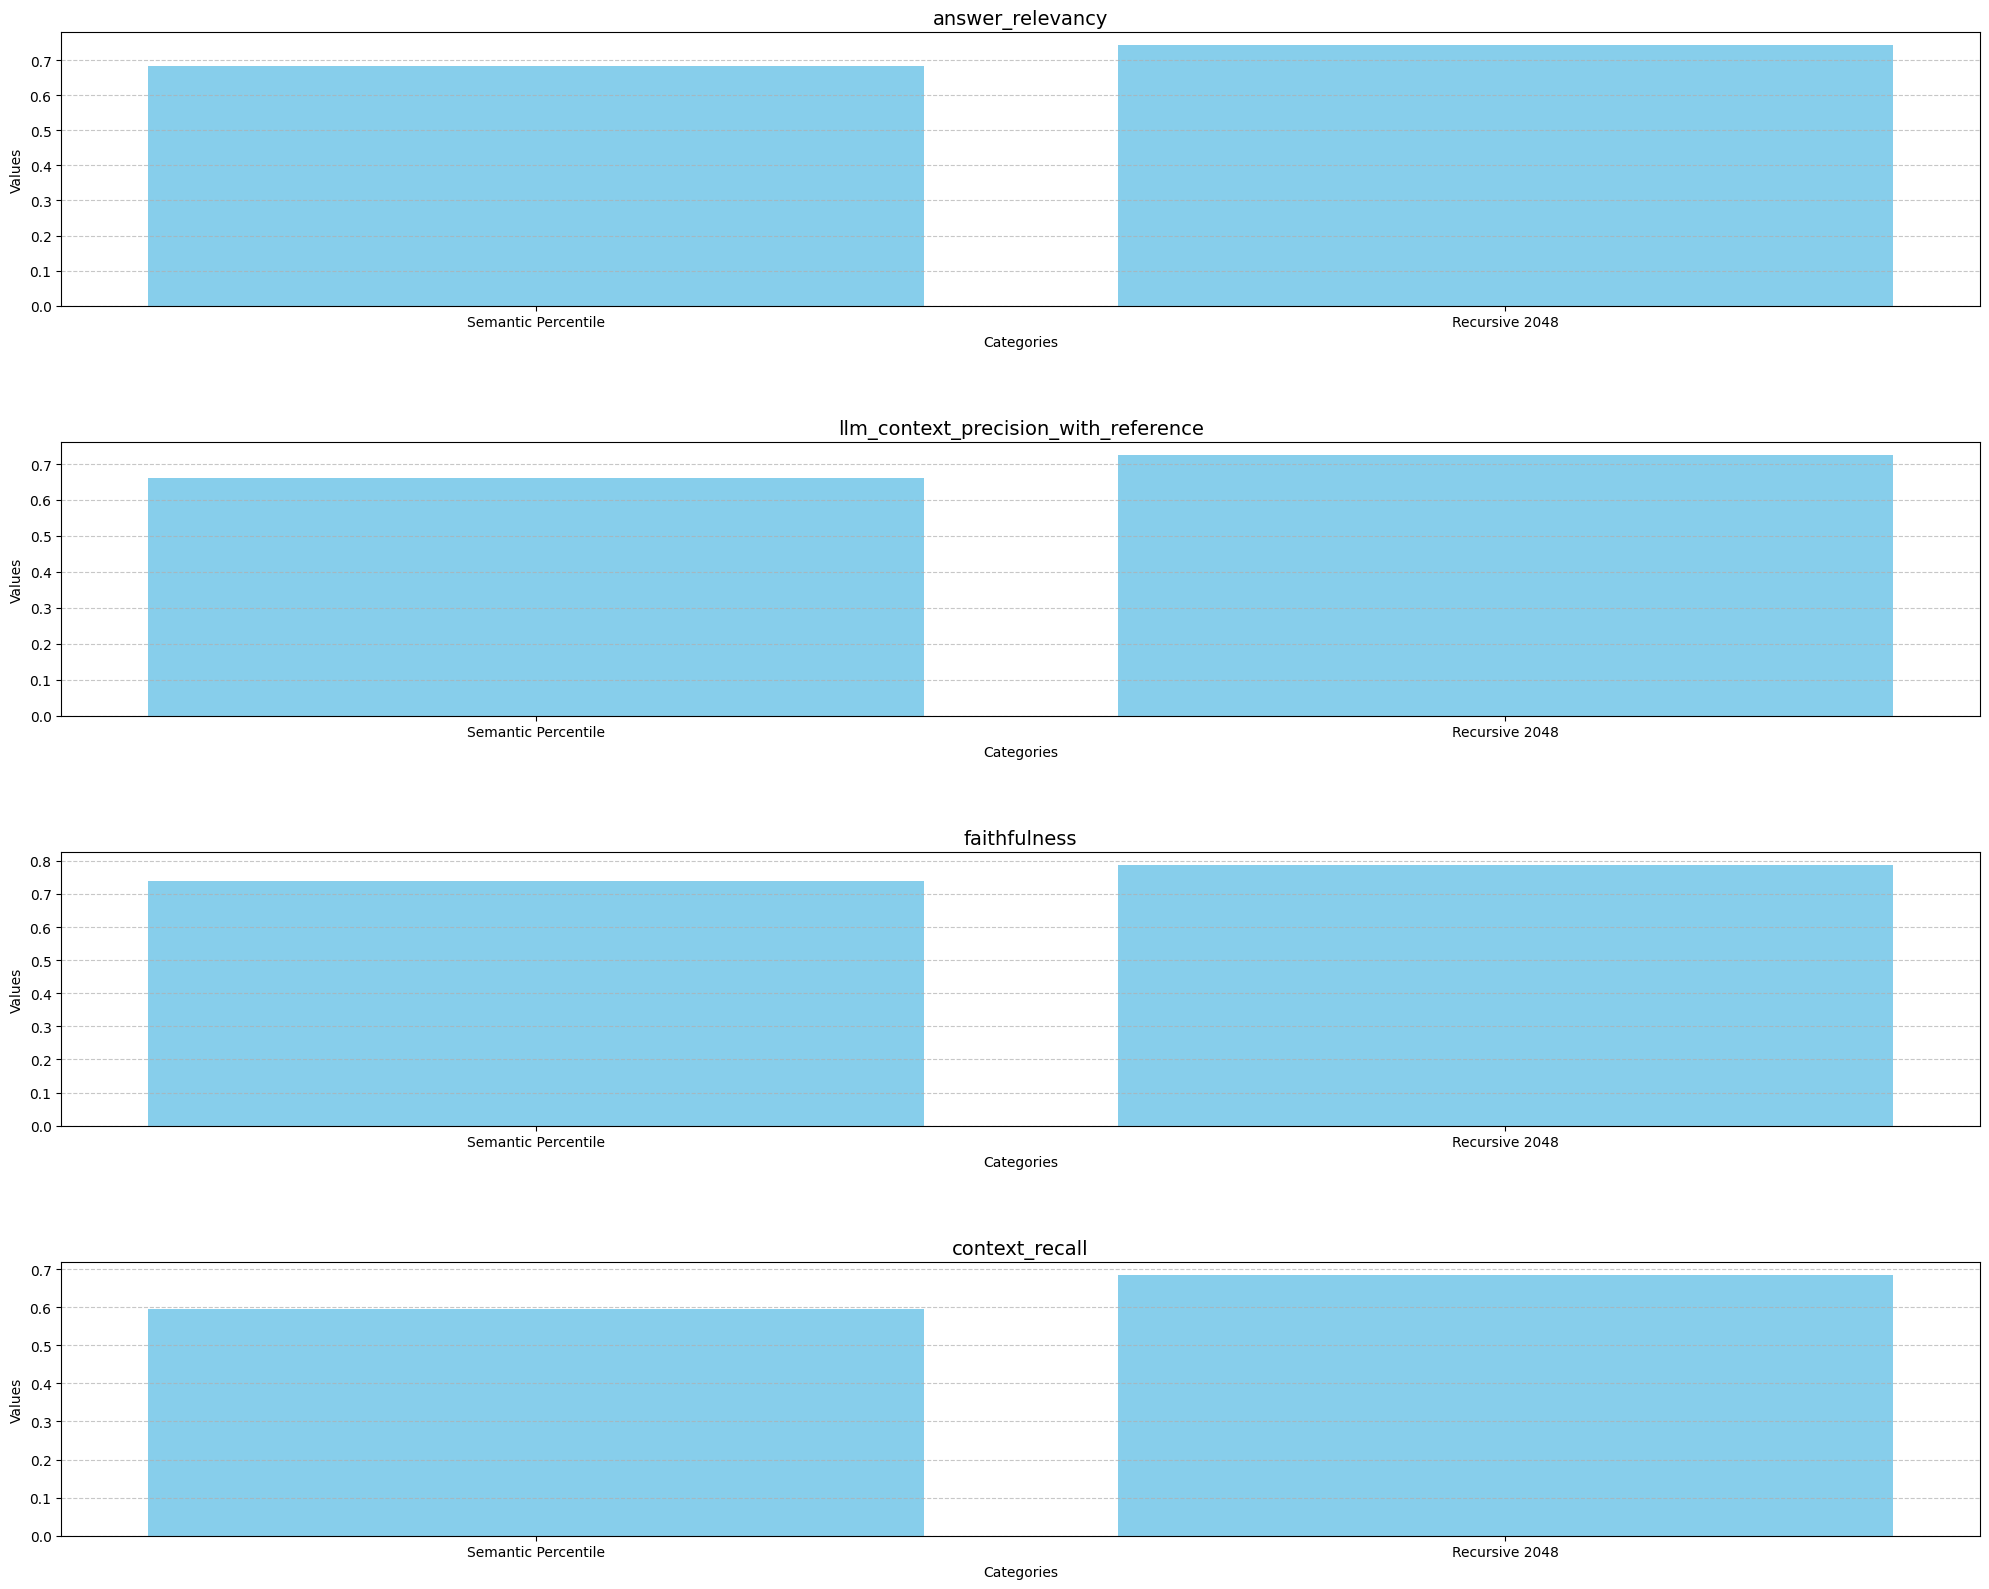

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# categories = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]

categories = ["Semantic Percentile", "Recursive 2048"]


metrics = ["answer_relevancy", "llm_context_precision_with_reference", "faithfulness", "context_recall"]

values = []
for m in metrics:
    values.append([
    np.mean(np.nan_to_num(result[m], nan=0)),

    np.mean(np.nan_to_num(result_2[m], nan=0))
])

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4,1, figsize=(20, 16))

# Titles for each subplot
titles = ['Plot 1', 'Plot 2', 'Plot 3', 'Plot 4']

# Iterate over each subplot and create a bar plot
for i, ax in enumerate(axs.flat):
    ax.bar(categories, values[i], color='skyblue')
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and add space between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()